#1. Mount Drive

In [1]:
import cv2
import time
import numpy as np
from google.colab.patches import cv2_imshow
import pandas as pd
from glob import glob
import IPython
from IPython.display import Image
from IPython.display import Audio
from IPython.core.display import display
from pytz import timezone
from datetime import datetime
!pip install pytz
print(cv2.__version__)

4.1.2


In [2]:
## 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
## cfg, weight, name 파일
weight_file = '/content/drive/MyDrive/최종프로젝트/자료/final/yolov3_training_5classes.weights'
cfg_file = '/content/drive/MyDrive/최종프로젝트/자료/final/yolov3_testing.cfg'
name_file = '/content/drive/MyDrive/최종프로젝트/자료/final/obj.names'

#2. Load File

In [4]:
min_confidence = 0.5

In [5]:
# Load Yolo
net = cv2.dnn.readNet(weight_file, cfg_file)

In [6]:
classes = []
with open(name_file, 'r') as f:
    classes = [line.strip() for line in f.readlines()]
print(classes)
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

colors = np.random.uniform(0, 255, size=(len(classes), 3))

['person', 'vest/HN', 'helmet', 'no_helmet', 'no_vest/HN']


## 함수 선언

In [7]:
## 함수 안에서는 Ipython의 Audio가 작동을 안해서 이것 저것 찾다보니 나온 임시방편 해결책.... 각각 함수화 시켜서 하면 소리가 잘 나더라고요

def beep0():
    display(Audio("/content/drive/MyDrive/최종프로젝트/코드/음성출력/한명만_서주세요.mp3", autoplay=True))
def beep1():
    display(Audio("/content/drive/MyDrive/최종프로젝트/코드/음성출력/정상입니다.mp3", autoplay=True))
def beep2():
    display(Audio("/content/drive/MyDrive/최종프로젝트/코드/음성출력/헬멧_미착용입니다.mp3", autoplay=True))
def beep3():
    display(Audio("/content/drive/MyDrive/최종프로젝트/코드/음성출력/조끼_미착용입니다.mp3", autoplay=True))
def beep4():
    display(Audio("/content/drive/MyDrive/최종프로젝트/코드/음성출력/다시_서주세요.mp3", autoplay=True)) 

## 객체 검출 후 그걸 데이터프레임으로 만들어주는 함수
def yoloimg(imgfile):
    # 이미지 가져오기
    img = imgfile
    # img = cv2.resize(img, None, fx=0.4, fy=0.4)
    height, width, channels = img.shape
    # Detecting objects
    blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)
    # 정보를 화면에 표시
    class_ids = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                # Object detected
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                # 좌표
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    font = cv2.FONT_HERSHEY_PLAIN

    # 객체 인식 이미지 출력
    font = cv2.FONT_HERSHEY_PLAIN
    for i in range(len(boxes)):
        # if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            color = colors[i]
            # cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
            cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
            cv2.putText(img, label, (x, y + 30), font, 3, color, 3)

    from google.colab.patches import cv2_imshow
    cv2_imshow(img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # 각 Class의 개수를 센 후 df에 넣어줌.
    countid = []
    for i in range(5):
        countid.append(class_ids.count(i))
    # jpgname = imgfile.split('/')[-1].split('.')[0]
    # df = pd.DataFrame({'jpgname':jpgname, 'Person':countid[0], 'Vest':countid[1], 'Helmet' : countid[2], 'NoHelmet' : countid[3], 'NoVest':countid[4]},  index=[0])
    df = pd.DataFrame({'Person':countid[0], 'Vest':countid[1], 'Helmet' : countid[2], 'NoHelmet' : countid[3], 'NoVest':countid[4]},  index=[0])
    return(df)


## 데이터프레임의 값에 따라 정해진 음성을 출력해주는 함수.
def audioout(df):
    if df.Person[0] >= 2:
        beep0()
    elif df.Person[0] == 1 and df.Helmet[0] == 1 and df.Vest[0]==1:
        beep1()
    elif df.Person[0] == 1 and df.Helmet[0] == 0 and df.Vest[0]==1:
        beep2()
    elif df.Person[0] == 1 and df.Helmet[0] == 1 and df.Vest[0] == 0:
        beep3()
    elif df.Person[0] == 1 and df.Helmet[0] == 0 and df.Vest[0] == 0:
        beep4()


## 함수들

In [8]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

# take_photo : 즉석에서 캡쳐해주는 함수
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);


      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
%Y

앞의 빈자리를 0으로 채우는 4자리 연도 숫자

%m

앞의 빈자리를 0으로 채우는 2자리 월 숫자

%d

앞의 빈자리를 0으로 채우는 2자리 일 숫자

%H

앞의 빈자리를 0으로 채우는 24시간 형식 2자리 시간 숫자

%M

앞의 빈자리를 0으로 채우는 2자리 분 숫자

In [ ]:

print(today)

2021-11-29 22:50:17.397120+09:00


<IPython.core.display.Javascript object>

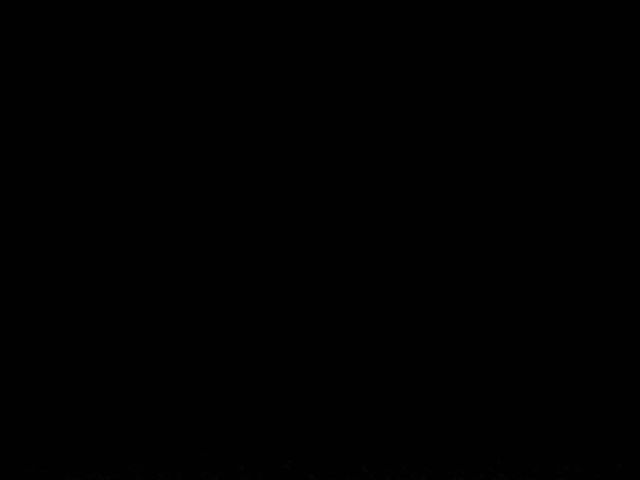

   Person  Vest  Helmet  NoHelmet  NoVest  ...  month  day  hour  minute  second
0       0     0       0         0       0  ...     11   30     9      22      28

[1 rows x 11 columns]


<IPython.core.display.Javascript object>

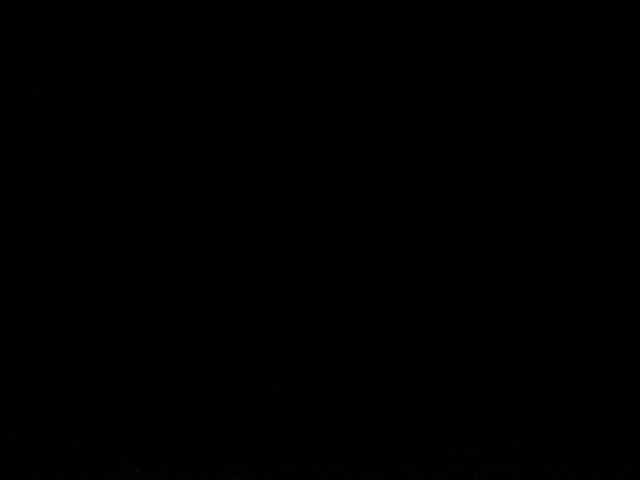

   Person  Vest  Helmet  NoHelmet  NoVest  ...  month  day  hour  minute  second
0       0     0       0         0       0  ...     11   30     9      22      28
0       0     0       0         0       0  ...     11   30     9      22      35

[2 rows x 11 columns]


<IPython.core.display.Javascript object>

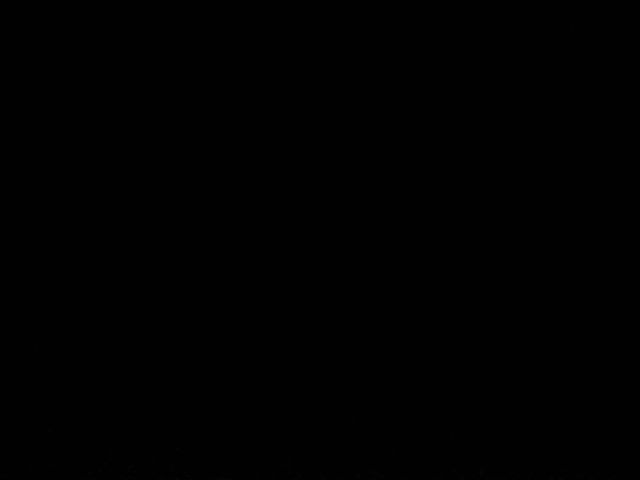

   Person  Vest  Helmet  NoHelmet  NoVest  ...  month  day  hour  minute  second
0       0     0       0         0       0  ...     11   30     9      22      28
0       0     0       0         0       0  ...     11   30     9      22      35
0       0     0       0         0       0  ...     11   30     9      22      43

[3 rows x 11 columns]


<IPython.core.display.Javascript object>

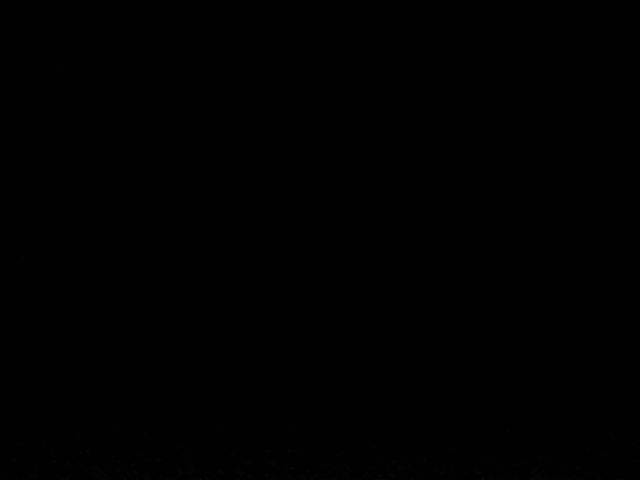

   Person  Vest  Helmet  NoHelmet  NoVest  ...  month  day  hour  minute  second
0       0     0       0         0       0  ...     11   30     9      22      28
0       0     0       0         0       0  ...     11   30     9      22      35
0       0     0       0         0       0  ...     11   30     9      22      43
0       0     0       0         0       0  ...     11   30     9      22      50

[4 rows x 11 columns]


<IPython.core.display.Javascript object>

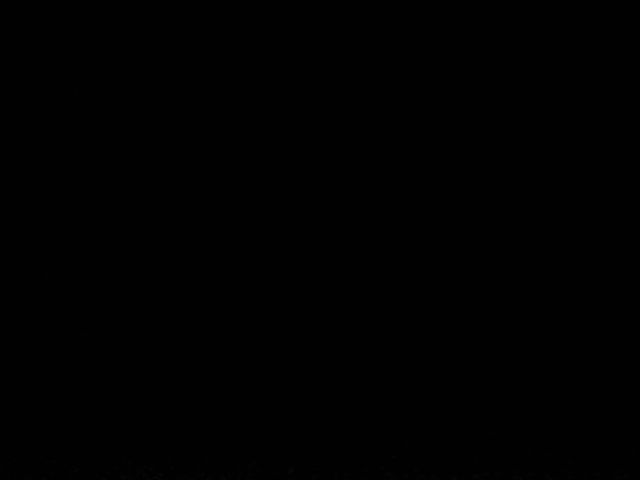

   Person  Vest  Helmet  NoHelmet  NoVest  ...  month  day  hour  minute  second
0       0     0       0         0       0  ...     11   30     9      22      28
0       0     0       0         0       0  ...     11   30     9      22      35
0       0     0       0         0       0  ...     11   30     9      22      43
0       0     0       0         0       0  ...     11   30     9      22      50
0       0     0       0         0       0  ...     11   30     9      22      58

[5 rows x 11 columns]


<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored

In [17]:
## 일정한 초단위로 작업
import time
import datetime as dt


result = []
i = 0
while True: # 몇번 동작할 것인지.
  time.sleep(3)   # 몇초 단위로 캡쳐할 것인지 (실험용으로 3초로 해놨습니다!) 
  take_photo()
  frame = cv2.imread('photo.jpg') # 캡쳐한 이미지를 openCV형식으로 전환
  df = yoloimg(frame)
  today = datetime.now(timezone('Asia/Seoul'))
  df['year'] = today.year
  df['month'] = today.month
  df['day'] = today.day
  df['hour'] = today.hour
  df['minute'] = today.minute
  df['second'] = today.second
  audioout(df)
  if i == 0:
      resultDF = df
  else:
      resultDF = pd.concat([resultDF, df])
  # result.append([df,today])
  # print(today)
  print(resultDF)   #result에 5초에 한번씩 인식하는 객체를 저장
  i += 1
  if i == 10800:    # i가 10800일 때 (9*60*60/3 업무시간 9시간을 초로 계산하여 timesleep 3으로 나눠준 값에서 조금 넉넉하게..)
    break      

In [13]:
df

,Person,Vest,Helmet,NoHelmet,NoVest,year,month,day,hour,minute,second
0,0,0,0,0,0,2021,11,30,9,16,9
